# Face Mask Detection with YOLOv5

YOLOv5: https://github.com/ultralytics/yolov5

In [1]:
import os
import re

## Downloading dataset

In [2]:
!pip install opendatasets --upgrade --q

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/andrewmvd/face-mask-detection'

od.download(dataset_url)

100%|██████████| 398M/398M [00:12<00:00, 34.2MB/s]


## Preprocessing data

In [4]:
data_dir = 'face-mask-detection/'

os.listdir(data_dir)

['images', 'annotations']

In [14]:
!mkdir -p {data_dir+'labels'}

In [5]:
dirs = {
    'img': data_dir + 'images/',
    'annot': data_dir + 'annotations/',
    'label': data_dir + 'labels/'
}

files = {}

for d in ['img', 'annot']:
    files.update({d: [f for f in os.listdir(dirs[d])]})
    files[d].sort(key = lambda i: int(re.sub('[^0-9]', '', i))) # sort file names in the correct order
    print(len(files[d]), files[d][:5])

853 ['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss2.png', 'maksssksksss3.png', 'maksssksksss4.png']
853 ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss2.xml', 'maksssksksss3.xml', 'maksssksksss4.xml']


#### Create Labels

[YOLO format](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) @ 1.2 Create Labels

In [6]:
def yolo_format(img_width, img_height, x_min, y_min, x_max, y_max):
    yolo_x = (x_max + x_min) / (2 * img_width)
    yolo_y = (y_max + y_min) / (2 * img_height)
    yolo_w = (x_max - x_min) / img_width
    yolo_h = (y_max - y_min) / img_height
    return yolo_x, yolo_y, yolo_w, yolo_h

In [16]:
from bs4 import BeautifulSoup

def create_box(obj, img_width, img_height):
    x_min = int(obj.find('xmin').text)
    y_min = int(obj.find('ymin').text)
    x_max = int(obj.find('xmax').text)
    y_max = int(obj.find('ymax').text)
    return yolo_format(img_width, img_height, x_min, y_min, x_max, y_max)

def create_class(obj):
    if obj.find('name').text == 'with_mask':
        return 1
    elif obj.find('name').text == 'mask_weared_incorrect':
        return 2
    return 0

files['label'] = []

def create_label(file):
    label_file = file.split('.')[0] + '.txt'
    files['label'].append(label_file)

    with open(dirs['annot']+file) as f:
        soup = BeautifulSoup(f, 'xml')
        objs = soup.find_all('object')
        
        img_width = int(soup.find('size').find('width').text)
        img_height = int(soup.find('size').find('height').text)

        with open(dirs['label']+label_file, 'w') as g:
            for obj in objs:
                class_num = create_class(obj)
                box = create_box(obj, img_width, img_height)
                g.write(str(class_num) + ' ' + ' '.join(map(str, box)) + '\n')

In [17]:
for file in files['annot']:
    create_label(file)

len(files['label']), files['label'][:5]

(853,
 ['maksssksksss0.txt',
  'maksssksksss1.txt',
  'maksssksksss2.txt',
  'maksssksksss3.txt',
  'maksssksksss4.txt'])

#### Create yaml file

In [21]:
import yaml

data_info = dict(
    path = '../' + data_dir,
    train = 'images/',
    val = 'images/',
    nc = 3,
    names = ['without_mask', 'with_mask', 'mask_weared_incorrect']
)

with open('../yolov5/data/face_mask.yaml', 'w') as f:
    yaml.dump(data_info, f)

## Downloading model

In [ ]:
%pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [19]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10881, done.
remote: Total 10881 (delta 0), reused 0 (delta 0), pack-reused 10881
Receiving objects: 100% (10881/10881), 10.98 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (7519/7519), done.
/content/yolov5


## Training

In [22]:
!python train.py --img 640 --batch 16 --epochs 10 \
    --data face_mask.yaml --weights yolov5l.pt

train: weights=yolov5l.pt, cfg=, data=face_mask.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-256-gee6c70a torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0

## Results

In [24]:
os.listdir('runs/train/exp/')

['events.out.tfevents.1645012544.2011c95fa06f.358.0',
 'train_batch2.jpg',
 'val_batch2_pred.jpg',
 'train_batch1.jpg',
 'R_curve.png',
 'confusion_matrix.png',
 'hyp.yaml',
 'val_batch1_labels.jpg',
 'F1_curve.png',
 'weights',
 'P_curve.png',
 'labels_correlogram.jpg',
 'val_batch0_labels.jpg',
 'results.png',
 'PR_curve.png',
 'val_batch2_labels.jpg',
 'val_batch1_pred.jpg',
 'labels.jpg',
 'opt.yaml',
 'val_batch0_pred.jpg',
 'train_batch0.jpg',
 'results.csv']

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

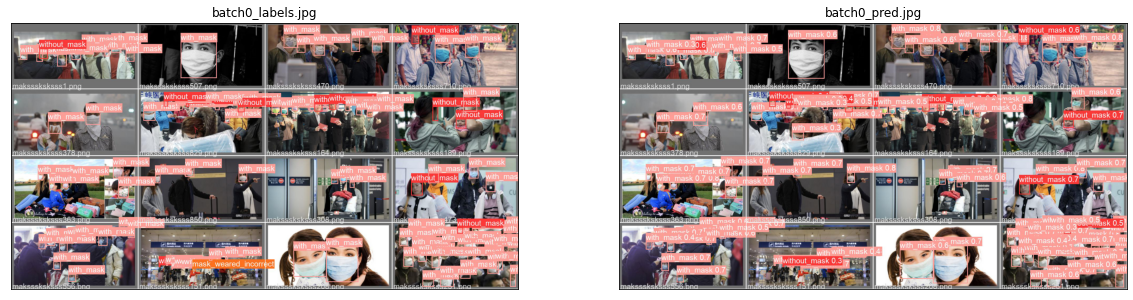

In [37]:
fig = plt.figure(figsize = (20, 20))
i = 0 # batch_index
idx = 0
for j in ['labels', 'pred']:
    idx += 1
    ax = fig.add_subplot(3, 2, idx, xticks=[], yticks=[])
    ax.imshow(plt.imread(f'runs/train/exp/val_batch{i}_{j}.jpg'))
    plt.title(f'batch{i}_{j}.jpg')

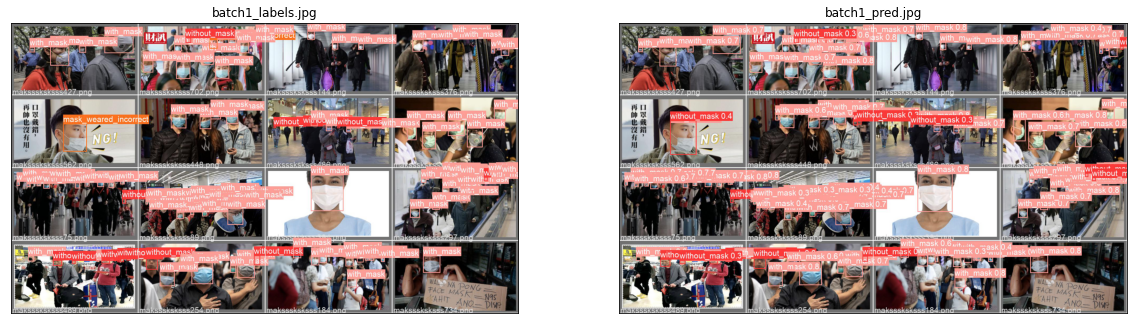

In [38]:
fig = plt.figure(figsize = (20, 20))
i = 1 # batch_index
idx = 0
for j in ['labels', 'pred']:
    idx += 1
    ax = fig.add_subplot(3, 2, idx, xticks=[], yticks=[])
    ax.imshow(plt.imread(f'runs/train/exp/val_batch{i}_{j}.jpg'))
    plt.title(f'batch{i}_{j}.jpg')

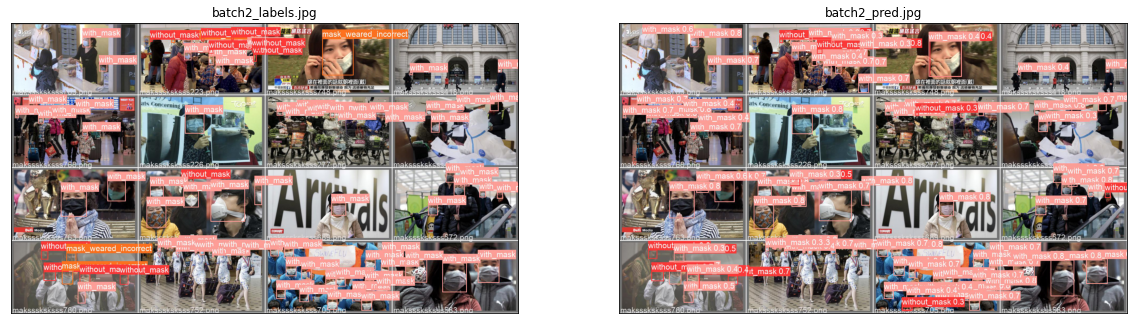

In [39]:
fig = plt.figure(figsize = (20, 20))
i = 2 # batch_index
idx = 0
for j in ['labels', 'pred']:
    idx += 1
    ax = fig.add_subplot(3, 2, idx, xticks=[], yticks=[])
    ax.imshow(plt.imread(f'runs/train/exp/val_batch{i}_{j}.jpg'))
    plt.title(f'batch{i}_{j}.jpg')

In [40]:
!zip -r /content/file.zip /content/yolov5/runs

  adding: content/yolov5/runs/ (stored 0%)
  adding: content/yolov5/runs/train/ (stored 0%)
  adding: content/yolov5/runs/train/exp/ (stored 0%)
  adding: content/yolov5/runs/train/exp/events.out.tfevents.1645012544.2011c95fa06f.358.0 (deflated 37%)
  adding: content/yolov5/runs/train/exp/train_batch2.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp/val_batch2_pred.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp/train_batch1.jpg (deflated 3%)
  adding: content/yolov5/runs/train/exp/R_curve.png (deflated 9%)
  adding: content/yolov5/runs/train/exp/confusion_matrix.png (deflated 26%)
  adding: content/yolov5/runs/train/exp/hyp.yaml (deflated 44%)
  adding: content/yolov5/runs/train/exp/val_batch1_labels.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp/F1_curve.png (deflated 10%)
  adding: content/yolov5/runs/train/exp/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp/weights/best.

In [41]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

- Quite good at detecting if a person is wearing mask or not
- Need more data to to detect people wearing mask incorrectly